In [ ]:
from __future__ import print_function
# Imports
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import tables
import sys
import pandas as pd

In [ ]:
# Read in data
h5file = tables.open_file("/Volumes/lidar_track/output_prism.h5")

rawmetadata = h5file.root.raw._v_attrs
rawmetadata_names = rawmetadata._f_list()

rawdata = pd.DataFrame(h5file.root.raw.data[:])

h5file.close()

In [ ]:
# Look at some metadata
print("Metadata names:", rawmetadata._f_list())
print()
print("Source energy:", rawmetadata.energy)
print("Number of particles:", rawmetadata.num_particles)

In [ ]:
# Copy into new dataframe
data = rawdata.copy()

# Remove zero energy events
data = data[data['E'] > 0]

# Blur energies
enfwhm = 0.05
data['E'] = np.random.normal(loc=data['E'].values, scale=(enfwhm*data['E'].values)/2.355)

# There is a chance some low energy events blur negative. Could set to 0 or remove. Just remove those events
data = data[(data['E'] > 0)]

# Apply hard energy threshold
data = data[data['E'] >= 30]

# Blur positions
# - assume constant 5 mm position resolution in X,Y and Z for now (arbitrary guess...)
# gaussian blur is separable filter - can do 3D blur with 3 1D blurs
posfwhm = 1
data['gx'] = np.random.normal(loc=data['gx'], scale=posfwhm/2.355)
data['gy'] = np.random.normal(loc=data['gy'], scale=posfwhm/2.355)
data['gz'] = np.random.normal(loc=data['gz'], scale=posfwhm/2.355)

In [36]:
data

,eventID,subeventID,trackID,detID,interaction,E,gx,gy,gz,dx,dy,dz
0,0,0,1,59,1,357.373445,-42.304660,-60.607221,-6.217922,-3.035480,3.442369,2.107565
1,0,1,1,59,1,155.463503,-43.562368,-60.474680,-6.839520,-2.925107,2.530592,2.201606
2,0,2,1,59,0,149.624228,-41.581001,-60.587425,-6.322752,-3.262249,3.232952,1.390453
3,13,0,1,19,1,80.769382,53.321475,21.928196,42.187878,3.284770,-0.977184,-0.351845
4,13,1,1,19,1,303.037154,54.148755,20.691135,39.380018,4.235703,2.505759,-2.151871
5,30,0,1,14,1,374.422133,-12.446294,-39.913390,55.741056,3.883525,-1.808322,-2.202215
6,30,1,1,14,1,128.424080,-12.719701,-40.760311,55.647765,4.357945,-1.392164,-1.769925
7,30,2,1,14,0,155.983475,-11.726745,-41.122604,55.153177,2.612294,-0.878140,-1.970603
8,38,0,1,98,1,416.070711,-9.638251,26.468916,-64.579146,1.140965,0.174684,-1.638515
9,38,1,1,90,0,250.565767,-25.984139,44.808117,-56.161796,1.920189,-1.190911,3.709794


In [37]:
# How many events
print "Events: %i" % len(data)

Events: 6184


In [38]:
# How many detectors
ndets = len(np.unique(data['detID'].values.astype(int)))
print "Detectors: %i" % ndets

Detectors: 104


<IPython.core.display.Javascript object>


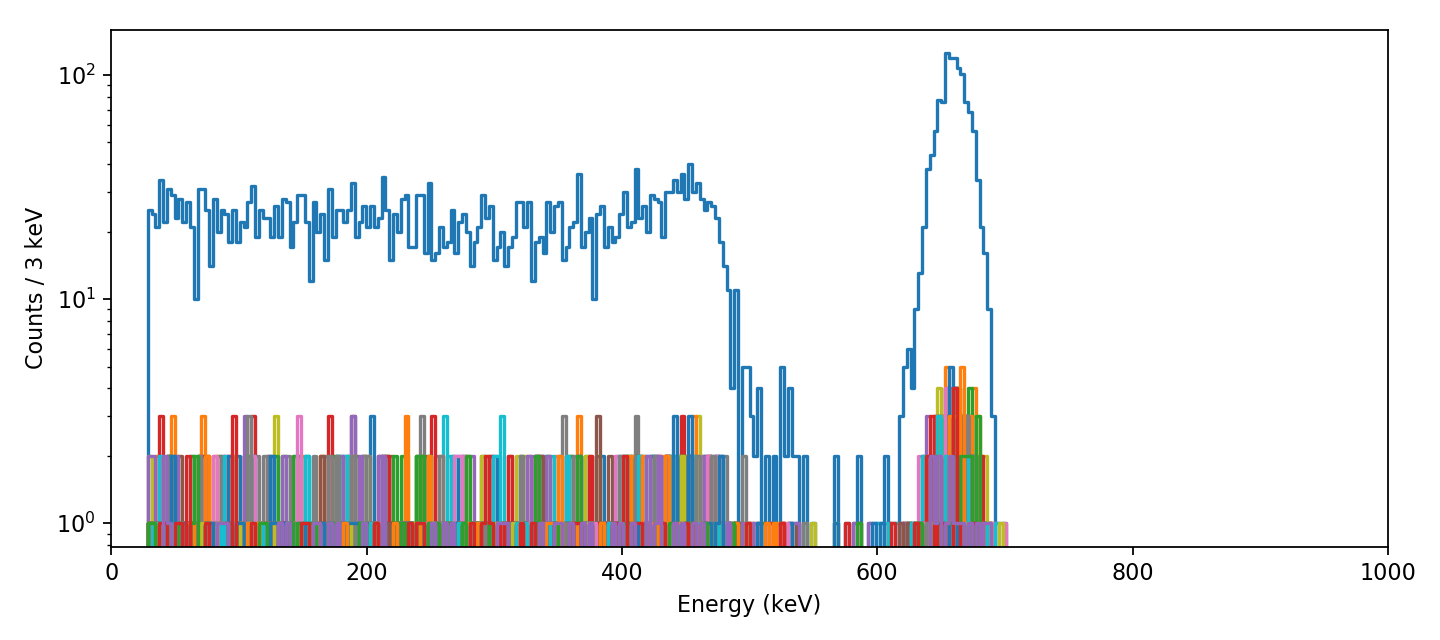

In [39]:
# Sum single crystal events, get energies
dg = data.groupby(['eventID', 'detID'])['E'].sum().reset_index()

# Plot energy spectra
plt.figure(figsize=(9,4))
spec, bins = np.histogram(dg['E'].values, bins=np.linspace(0,3072,1024))
bins = (bins[1:] + bins[:-1])/2.
plt.plot(bins, spec, drawstyle='steps', label="Combined")
for i in range(ndets):
    spec_, _ = np.histogram(dg[dg['detID'] == i]['E'].values, bins=np.linspace(0,3072,1024))
    plt.plot(bins, spec_, drawstyle='steps', label='Detector %i' % i)
plt.yscale('log')
plt.xlim(0,1000)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts / 3 keV")
# plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


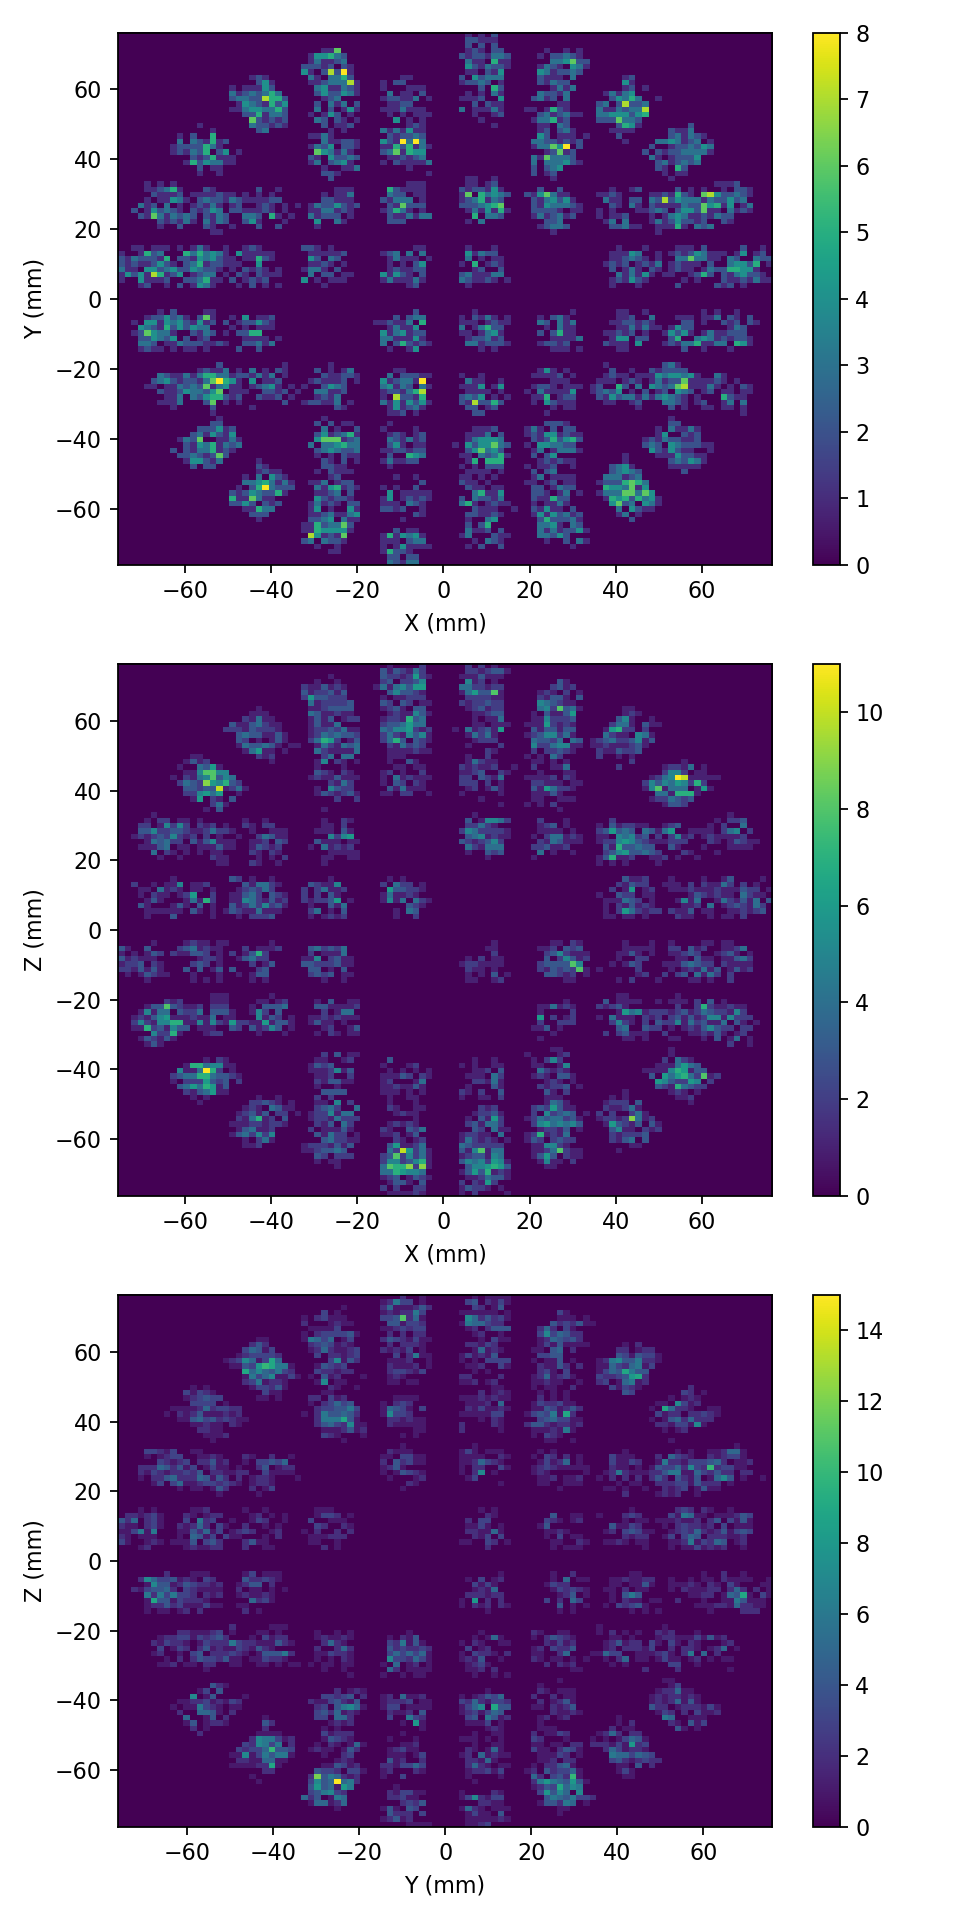

In [40]:
# Heatmap of interaction locations
plt.figure(figsize=(6,12))
# XY
plt.subplot(311)
plt.hist2d(data['gx'], data['gy'], bins=100)
plt.colorbar()
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
# XZ
plt.subplot(312)
plt.hist2d(data['gx'], data['gz'], bins=100)
plt.colorbar()
plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")
# YZ
plt.subplot(313)
plt.hist2d(data['gy'], data['gz'], bins=100)
plt.colorbar()
plt.xlabel("Y (mm)")
plt.ylabel("Z (mm)")
# Render
plt.tight_layout()
plt.show()